# Investigate Postgresql quality control tables


For this notebook to run one must be connected to the IoA VPN. You also need a local credentials.py file with the connection credentials.

In [67]:
import psycopg2
import psycopg2 as pg2
from psycopg2 import extras
import sys, os
import numpy as np
import pandas as pd
import pandas.io.sql as psql
from astropy.table import Table
import numpy as np
from os import stat, path
import matplotlib.pyplot as plt
%matplotlib inline

#local file with private PGHOST,PGDATABASE,PGUSER,PGPASSWORD values
import credentials as creds

In [45]:

colour_dict = {'Z':'blue','Y':'green','J':'yellow','H':'orange','Ks':'red'}


In [40]:
def str_to_astropy(query_str):
    """Take a postgresql query string and return an astropy table"""
    conn = pg2.connect(
        host=creds.PGHOST, 
        user=creds.PGUSER,
        database=creds.PGDATABASE,
        password=creds.PGPASSWORD
    )
    if query_str==None:
        query_str = """
        SELECT COUNT(*)
        FROM vistaqc
        """
    dat = pd.read_sql_query(query_str, conn)
    tab=Table.from_pandas(dat)
    conn = None
    return tab


In [54]:
test=str_to_astropy("""
SELECT *
FROM vistaqc
limit 5
    """)

In [55]:
test

image_id,filename,origfile,esoname,obj,obscat,obstech,obstype,filepath,ra,dec,glon,glat,coords,equinox,radecsys,image_exptime,exectime,totexptime,mjd,dateobs,nightobs,utc,lst,picoi,observer,obscat_id,obstech_id,obstype_id,insfilter_id,inspres1,obsdid_id,obsid,obsname,irunno,obspicoiid,obspicoiname,obsstart,obstplno,ocsrecipe,ocsreqtime,amstart,amend,alt,telfwhmstart,telfwhmend,obsairm,obsfwhm,obstrans,obscontainerid,obscontainertype,obsgrp,obsmoondist,obsmoonfli,telapstart,telapend,telrhum,teltau0,teltemp,winddir,windsp,az,parangstart,parangend,moon_ra,moon_dec,posang,tpldid_id,tplexpno,tplid,tplname,tplnexp,tplstart,njitter,noffsets,nustep,obsnum,reqtime,jitterx,jittery,offsetx,offsety,programme_id,semester_id,jittername,offsetname,skyalgo,is_checked,version,is_public,is_tile,is_stack,st_mtime,bitpix,naxis1,naxis2,exptime,extension_mjd,extension_dateobs,ctype1,ctype2,crval1,crval2,crpix1,crpix2,cd1_1,cd1_2,cd2_1,cd2_2,pv2_1,pv2_2,pv2_3,pv2_4,pv2_5,detdid_id,detdit,chiplife,chipno,detframno,detframtype,detmodename,detncorrs,winnx,winny,winstartx,winstarty,expname,expno,runno,mindit,ndit,nditskip,nditcor,cenra,cendec,cencoords,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,dribble,pixsize,nprov,cirvers,saturation,ellipticity,magzpt,magzerr,magznpt,darkcor,flatcor,lincor,skysub,confmap,stripecor,striperms,skylevel,skynoise,stdcrms,numbrms,classifd,threshol,minpix,crowded,rcore,seeing,filtfwhm,extinct,maglim,skybright,ebmvmed,apcorpk,apcor1,apcor2,apcor3,apcor4,apcor5,apcor6,apcor7,nobjects,imcorever,catcoordver,classver,classpver,photompver,extension_id,nightzpt,nightzrr,nightnum,prog,semester,surveyname,groupname,obstatus,qcstatus,filtname,filtid,effwave,sunset,sunrise,dusk,dawn,moonrise,moonset,moonphase,moonaltsunrise,moonaltsunset,moonaltdawn,moonaltdusk,magzp1,magzp2,magzp3,magzp4,magzp5,magzp6,magzp_max,magzp_min,ellpt1,ellpt2,ellpt3,ellpt4,ellpt5,ellpt6,ellpt_max,ellpt_min,seeng1,seeng2,seeng3,seeng4,seeng5,seeng6,seeng_max,seeng_min
int64,str22,str27,str34,str4,str7,str12,str6,str38,float64,float64,float64,float64,str23,float64,str3,float64,float64,float64,float64,object,int64,float64,float64,str7,str7,int64,int64,int64,int64,float64,int64,int64,str9,float64,int64,str7,object,int64,str7,float64,float64,float64,float64,float64,float64,float64,float64,str4,int64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str20,str25,int64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,str9,str6,str7,bool,float64,bool,bool,bool,object,int64,int64,int64,float64,float64,object,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bool,int64,int64,str3,str1,int64,int64,int64,object,object,str22,int64,float64,float64,int64,int64,bool,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,int64,float64,float64,float64,float64,float64,float64,str21,str20,str17,str23,str27,bool,float64,float64,float64,float64,int64,bool,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,object,object,object,object,int64,float64,float64,float64,str10,str1,str3,str8,str9,str1,str2,str5,float64,object,object,object,object,object,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
682656,v20120716_00145_st.fit,VIRCAM_IMG_OBS198_0097.fits,VCAM.2012-07-16T23:46:24.3695.fits,b370,SCIENCE,"IMAGE,JITTER",OBJECT,/data/apm44_e/vista/processed/20120716,258.051379,-33.66802,352.10908934,3.32484586206,17:12:12.33 -33:40:04.9,2000.0,FK5,4.0,363.0,8.0,56124.9905599,2012-07-16T23:46:24.000,20120716,85583.0,53139.173,UNKNOWN,UNKNOWN,2,1,3,2,0.0,5,716146,b370v-029,2.012071600145009e+

In [56]:
test.colnames

['image_id',
 'filename',
 'origfile',
 'esoname',
 'obj',
 'obscat',
 'obstech',
 'obstype',
 'filepath',
 'ra',
 'dec',
 'glon',
 'glat',
 'coords',
 'equinox',
 'radecsys',
 'image_exptime',
 'exectime',
 'totexptime',
 'mjd',
 'dateobs',
 'nightobs',
 'utc',
 'lst',
 'picoi',
 'observer',
 'obscat_id',
 'obstech_id',
 'obstype_id',
 'insfilter_id',
 'inspres1',
 'obsdid_id',
 'obsid',
 'obsname',
 'irunno',
 'obspicoiid',
 'obspicoiname',
 'obsstart',
 'obstplno',
 'ocsrecipe',
 'ocsreqtime',
 'amstart',
 'amend',
 'alt',
 'telfwhmstart',
 'telfwhmend',
 'obsairm',
 'obsfwhm',
 'obstrans',
 'obscontainerid',
 'obscontainertype',
 'obsgrp',
 'obsmoondist',
 'obsmoonfli',
 'telapstart',
 'telapend',
 'telrhum',
 'teltau0',
 'teltemp',
 'winddir',
 'windsp',
 'az',
 'parangstart',
 'parangend',
 'moon_ra',
 'moon_dec',
 'posang',
 'tpldid_id',
 'tplexpno',
 'tplid',
 'tplname',
 'tplnexp',
 'tplstart',
 'njitter',
 'noffsets',
 'nustep',
 'obsnum',
 'reqtime',
 'jitterx',
 'jittery',


In [57]:
len(test.colnames)

237

In [58]:
surveys=str_to_astropy("""
SELECT DISTINCT surveyname
FROM vistaqc
    """)
surveys

surveyname
str11
JVarCar
GT980
VVVLight
VIDEO
NBCosmos
Simon
Calib
SV
UltraVISTA


In [52]:
count=str_to_astropy("""
SELECT COUNT(*)
FROM vistaqc
    """)
count

count
int64
11121212


In [69]:
video_ims = str_to_astropy("""
SELECT 
    filename,
    saturation,
    ellipticity,
    magzpt,
    skylevel,
    skynoise, 
    qcstatus,
    filtname, 
    maglim, 
    seeing
FROM vistaqc 
WHERE surveyname='VIDEO'
""")

In [70]:
video_ims[:5]

filename,saturation,ellipticity,magzpt,skylevel,skynoise,qcstatus,filtname,maglim,seeing
str25,float64,float64,float64,float64,float64,str1,str2,float64,float64
v20180107_00131_st.fit,49639.11,0.05647552,23.236,767.47,7.47,A,Y,20.8706895438,0.705008396858928
v20180107_00131_st.fit,32233.97,0.05285168,23.257,847.44,4.45,A,Y,21.4859819208,0.621394098088601
v20180107_00131_st.fit,40353.38,0.07023847,23.272,839.3,4.5,A,Y,21.4717884639,0.645294164064404
v20180107_00131_st.fit,45139.42,0.04808843,23.279,828.46,5.05,A,Y,21.345691003,0.704216197049145
v20180107_00131_st.fit,30248.94,0.03211105,23.236,808.76,4.58,A,Y,21.4385094533,0.662796287728603


In [71]:
np.sum(video_ims['filename']=='v20180107_00131_st.fit')

16

In [72]:
for filt in colour_dict:
    print(filt,colour_dict[filt])

Z blue
Y green
J yellow
H orange
Ks red


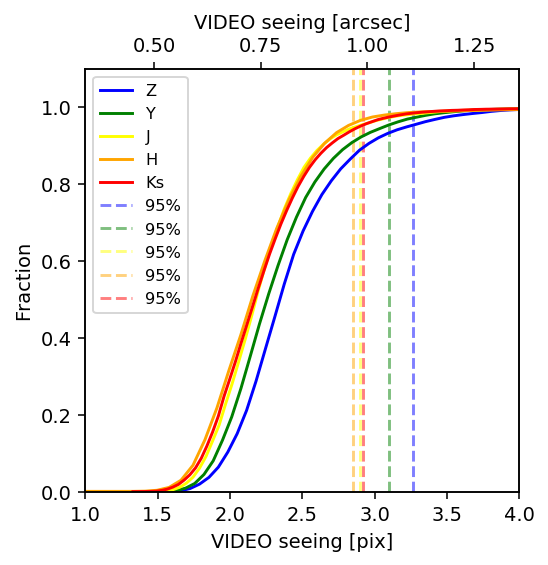

In [109]:
fig = plt.figure(figsize=(4, 4), dpi=140)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
lims=[1,4]
pixwidth=0.339
#hist=np.histogram(video_ims[near_sxds]['SEEING'],bins=100)
#X=[np.mean([hist[1][n],hist[1][n+1]]) for n in np.arange(len(hist[1])-1)] 
#Y=hist[0]
for band in colour_dict:

    #print(band)
    m = (video_ims['filtname']==band)


    hist=np.histogram(video_ims[m]['seeing']/pixwidth,bins=100)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    ax1.plot(bin_middles,cum_sum,label=band,c=colour_dict[band])

    ax1.set_ylim([0,1.1])
    ax1.set_xlabel(r"VIDEO seeing [pix]")
    ax1.set_xlim(lims)
    ax1.set_ylabel('Fraction')
    

    seeing_p95=np.nanpercentile(video_ims[m]['seeing']/pixwidth,95)
    ax1.vlines(seeing_p95,0,1.1,label='95%',color=colour_dict[band],alpha=0.5,linestyle='--')

ax1.legend(fontsize='small')

new_tick_locations = np.array([0.5,0.75,1,1.25])/pixwidth
def tick_function(X):
    V = X*pixwidth
    return ["%.2f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"VIDEO seeing [arcsec]")
fig.savefig('./figs/video_seeing_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/video_seeing_hist.png', overwrite=True, bbox_inches='tight')

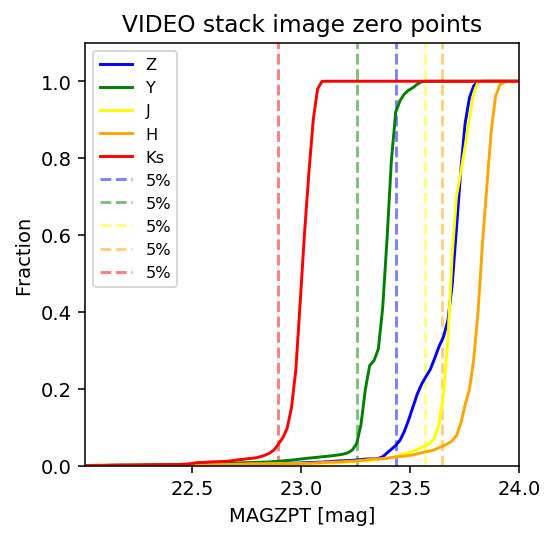

In [88]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)

x_lims=[
    np.nanpercentile(video_ims['magzpt'],1),
    np.nanpercentile(video_ims['magzpt'],99.9)+0.5
]
x_lims=[22.01,24.]
ax.set_title('VIDEO stack image zero points')
for band in colour_dict:

    #print(band)
    m = (video_ims['seeing']>0) & (video_ims['filtname']==band)


    zp_p1_band=np.nanpercentile(video_ims[m]['magzpt'],1)
    
    med = np.nanmedian(video_ims[m]['magzpt'])
    std = np.nanstd(video_ims[m]['magzpt'])


    hist=np.histogram(video_ims[m]['magzpt'],bins=100,range=x_lims)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    line=ax.plot(bin_middles,cum_sum,label=band,c=colour_dict[band])
    #ax.vlines(med-5*std,0,1.1,colors=line[0].get_color(),alpha=0.5,label='median-5$\sigma$')
    p5=np.nanpercentile(video_ims[m]['magzpt'],5)
    ax.vlines(p5,0,1.1,label='5%',color=colour_dict[band],alpha=0.5,linestyle='--')
    

 
ax.set_ylim([0,1.1])
ax.set_xlim(x_lims)

ax.set_xlabel(r"MAGZPT [mag]")
#ax.set_xlim(lims)
ax.set_ylabel('Fraction')
ax.legend(fontsize='small')
fig.savefig('./figs/video_zp_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/video_zp_hist.png', overwrite=True, bbox_inches='tight')

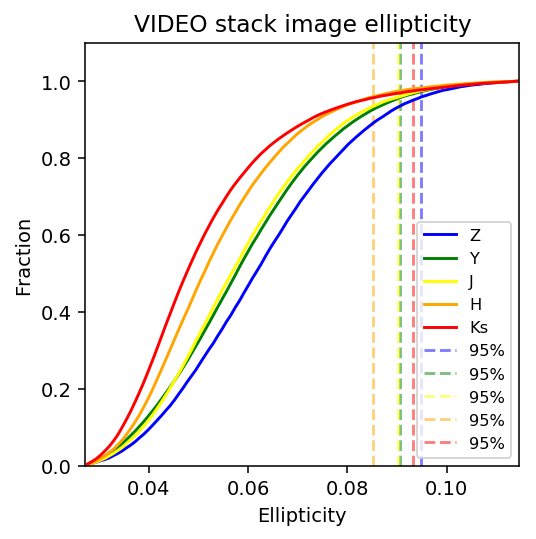

In [94]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)

x_lims=[
    np.nanpercentile(video_ims['ellipticity'],1),
    np.nanpercentile(video_ims['ellipticity'],99.)
]
#x_lims=[22.01,24.]
ax.set_title('VIDEO stack image ellipticity')
for band in colour_dict:

    #print(band)
    m =  (video_ims['filtname']==band)


    zp_p1_band=np.nanpercentile(video_ims[m]['ellipticity'],1)
    
    med = np.nanmedian(video_ims[m]['ellipticity'])
    std = np.nanstd(video_ims[m]['ellipticity'])


    hist=np.histogram(video_ims[m]['ellipticity'],bins=100,range=x_lims)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    line=ax.plot(bin_middles,cum_sum,label=band,c=colour_dict[band])
    #ax.vlines(med-5*std,0,1.1,colors=line[0].get_color(),alpha=0.5,label='median-5$\sigma$')
    p95=np.nanpercentile(video_ims[m]['ellipticity'],95)
    ax.vlines(p95,0,1.1,label='95%',color=colour_dict[band],alpha=0.5,linestyle='--')
    

 
ax.set_ylim([0,1.1])
ax.set_xlim(x_lims)

ax.set_xlabel(r"Ellipticity")
#ax.set_xlim(lims)
ax.set_ylabel('Fraction')
ax.legend(fontsize='small')
fig.savefig('./figs/video_ellipticity_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/video_ellipticity_hist.png', overwrite=True, bbox_inches='tight')

In [97]:
import seaborn as sns

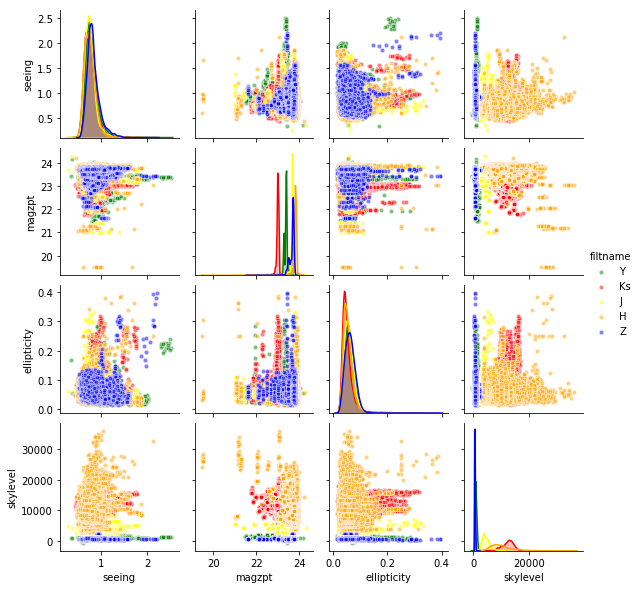

In [147]:
#fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
m=(video_ims['seeing']>0.)&(video_ims['magzpt']>1.)&(video_ims['ellipticity']>0.)

sns_plot=sns.pairplot(
    video_ims[m]['seeing','magzpt','ellipticity','skylevel','filtname'].to_pandas(), 
    plot_kws={'alpha':.5,'s':80,'rasterized':True,'marker':'.','edgecolors':None,'linewidths':0.},
    height=2,
    hue="filtname",palette=colour_dict)
sns_plot.savefig("./figs/corner_plots.png")
#sns_plot.savefig("./figs/corner_plots.pdf") #this seems to break things

In [151]:
from functools import partial

/Users/raphaelshirley/Documents/github/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.patches.Patch object at 0x7fcbf310a3d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


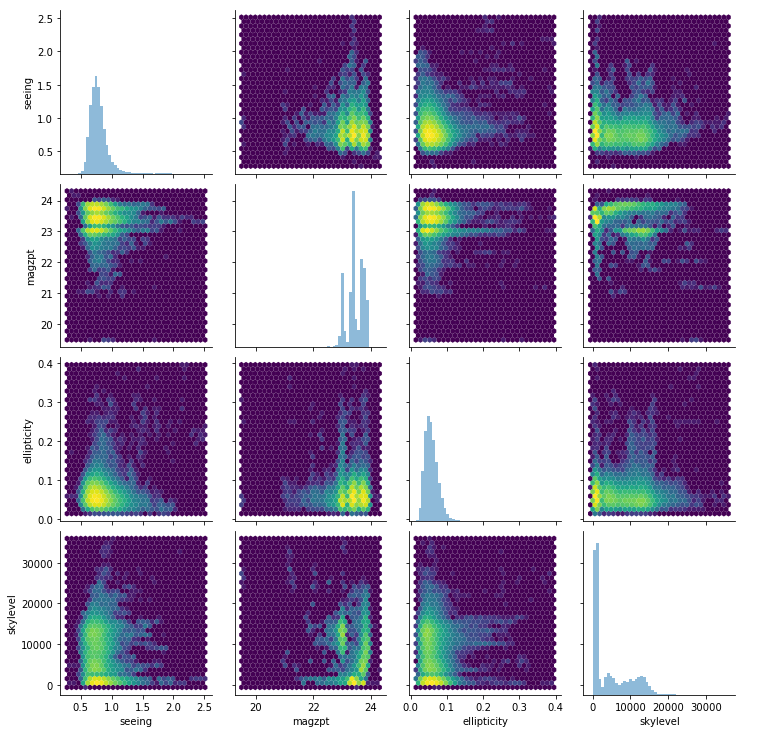

In [163]:
g = sns.PairGrid(video_ims[m]['seeing','magzpt','ellipticity','skylevel'].to_pandas())
g.map_diag(partial(plt.hist,bins=50,alpha=0.5))
g.map_offdiag(partial(plt.hexbin,gridsize=30, bins='log', edgecolors=None,linewidths=0.))
g.add_legend()
g.savefig("./figs/corner_hex_plots.png")